In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import utils3
import utils2

In [2]:
color_pal = sns.color_palette()

## Reading in files and indexing them on time

In [3]:
targets_a = pd.read_parquet('../data/A/train_targets.parquet')
targets_b = pd.read_parquet('../data/B/train_targets.parquet')
targets_c = pd.read_parquet('../data/C/train_targets.parquet')
targets_a = targets_a.set_index('time')
targets_b = targets_b.set_index("time")
targets_c = targets_c.set_index("time")


In [4]:
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")


In [5]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


In [6]:
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")


## Some EDA

In [7]:
targets_a.describe()

,pv_measurement
count,34085.000000
mean,630.594707
std,1165.902422
min,0.000000
25%,0.000000
50%,5.940000
75%,678.040000
max,5733.420000


In [8]:
# Notice that missing rows are simply non-existent for targets_a, not filled with NaN or anything
# From 21. october
display(targets_a[29660:29670])

,pv_measurement
time,
2022-10-20 18:00:00,0.0
2022-10-20 19:00:00,0.0
2022-10-20 20:00:00,0.0
2022-10-20 21:00:00,0.0
2022-10-20 22:00:00,0.0
2022-10-20 23:00:00,0.0
2022-10-21 00:00:00,0.0
2022-10-28 22:00:00,0.0
2022-10-28 23:00:00,0.0


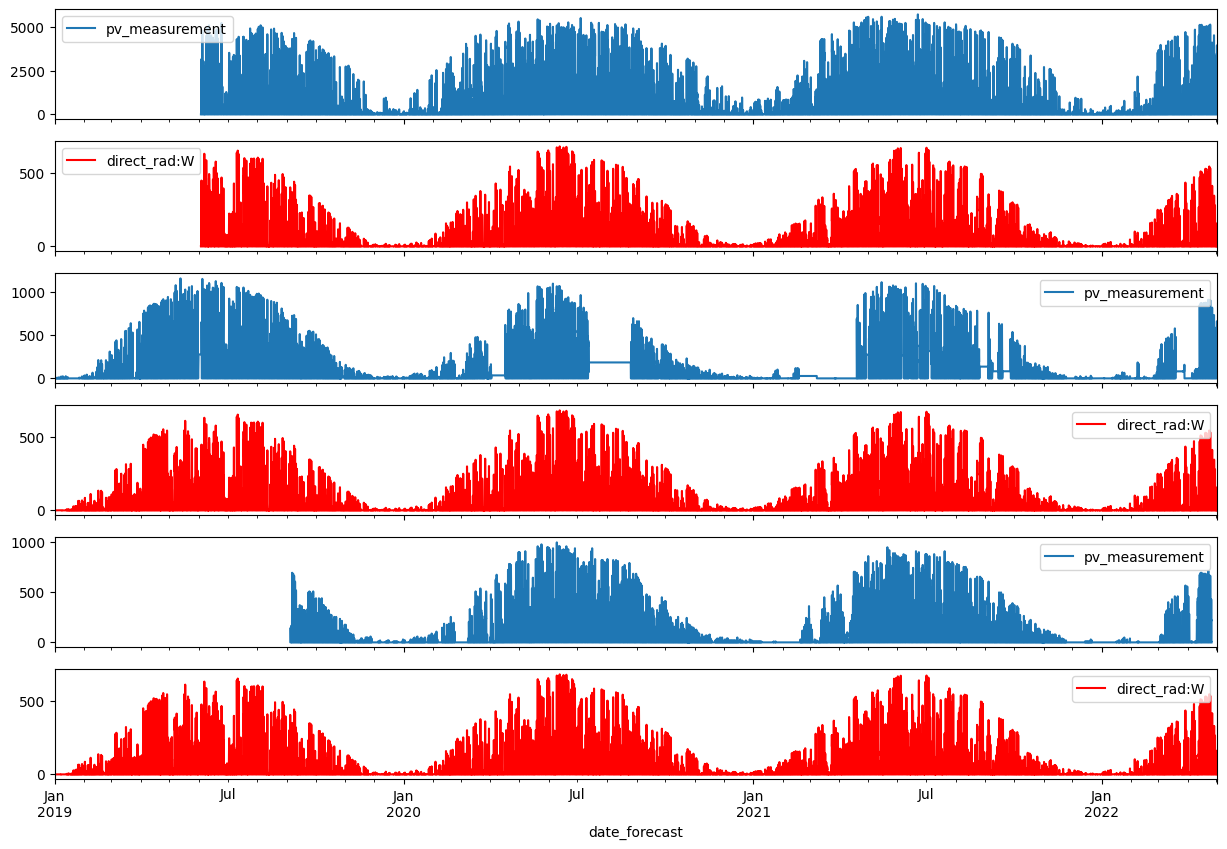

In [9]:
### generalized plotting
start_date = '2019'
end_date = '2024'

feature_name = "direct_rad:W"

Y = [targets_a, targets_b, targets_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]

utils3.plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

## Data Preprocessing

34085 32848 32155
34085 21871 26095


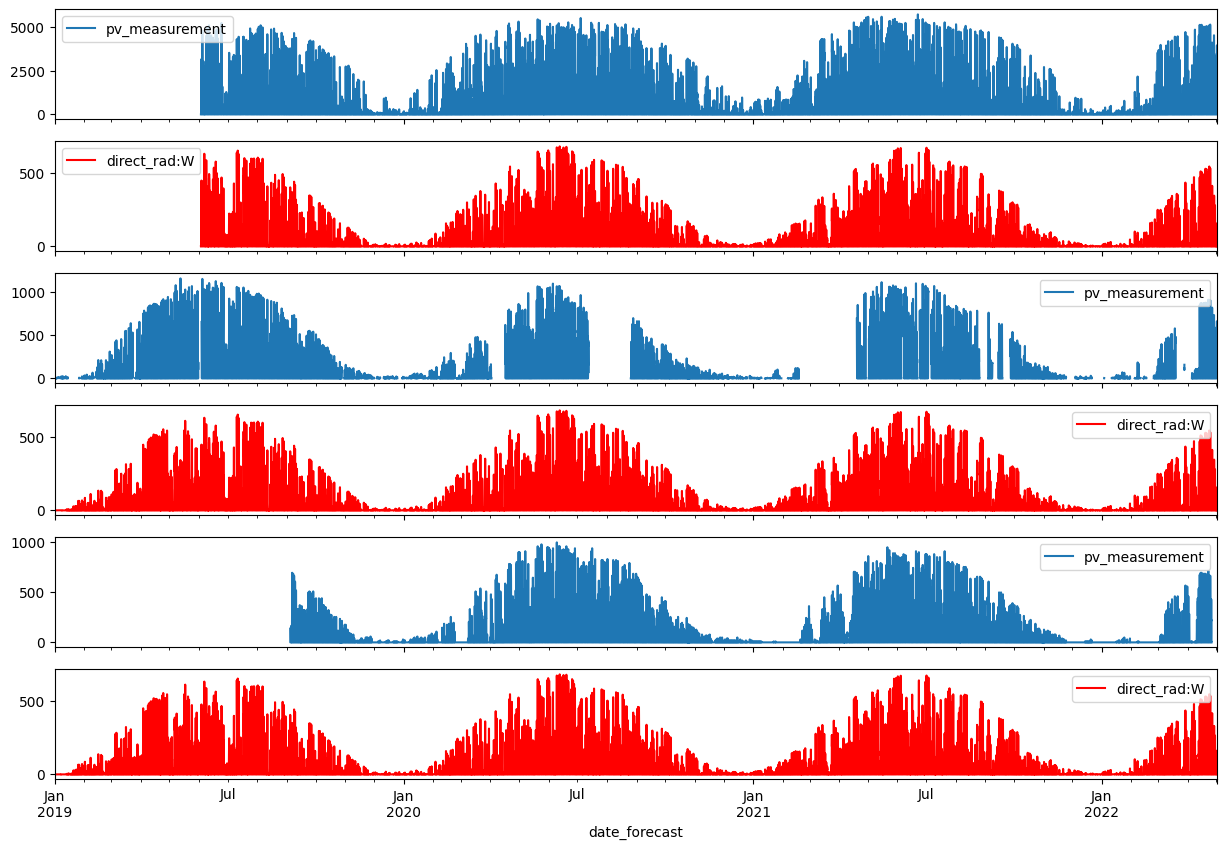

In [10]:
print(targets_a.size, targets_b.size, targets_c.size)

# removing rows where pv_measurment remains the same for more than 24 hours.
targets_a = utils3.remove_constant_values(targets_a, "pv_measurement", 18).dropna()
targets_b = utils2.remove_constant_values(targets_b, "pv_measurement", 18).dropna()
targets_c = utils3.remove_constant_values(targets_c, "pv_measurement", 18).dropna()

print(targets_a.size, targets_b.size, targets_c.size)

Y = [targets_a, targets_b, targets_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]

start_date = '2019'
end_date = '2024'
feature_name = "direct_rad:W"

utils3.plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

In [11]:
### Adding more time based features to the datasets
X_train_observed_a = utils3.create_features(X_train_observed_a)
X_train_observed_b = utils3.create_features(X_train_observed_b)
X_train_observed_c = utils3.create_features(X_train_observed_c)

X_train_estimated_a = utils3.create_features(X_train_estimated_a)
X_train_estimated_b = utils3.create_features(X_train_estimated_b)
X_train_estimated_c = utils3.create_features(X_train_estimated_c)

X_test_estimated_a = utils3.create_features(X_test_estimated_a)
X_test_estimated_b = utils3.create_features(X_test_estimated_b)
X_test_estimated_c = utils3.create_features(X_test_estimated_c)

In [12]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, targets_a, left_index=True, right_index=True)
train_b = pd.merge(X_train_observed_b, targets_b, left_index=True, right_index=True)
train_c = pd.merge(X_train_observed_c, targets_c, left_index=True, right_index=True)


In [13]:
# Check which features most correlated with y
correlations = train_a.corrwith(train_a["pv_measurement"])
for index, corr in correlations.items():
    correlations[index] = abs(corr)

sorted = correlations.sort_values(ascending=False)
best_features = list(sorted[1:10].index)
print(best_features)

['direct_rad:W', 'direct_rad_1h:J', 'clear_sky_rad:W', 'clear_sky_energy_1h:J', 'diffuse_rad:W', 'sun_elevation:d', 'diffuse_rad_1h:J', 'is_in_shadow:idx', 'is_day:idx']


## Create our model

In [14]:
FEATURES = list(train_a.columns[:-1]) # Using all the features of X.
FEATURES_b = list(train_b.columns[:-1].drop("month"))
TARGETS = "pv_measurement"

### DATA
X_a = train_a[FEATURES]
y_a = train_a[TARGETS]
X_b = train_b[FEATURES_b]
y_b = train_b[TARGETS]
X_c = train_c[FEATURES]
y_c = train_c[TARGETS]

### Location A

In [15]:
### Location A

### If using validation set, split the data into training and testing sets 
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_A = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_A.fit(X_train_a, y_train_a,
        eval_set = [(X_train_a, y_train_a), (X_test_a, y_test_a)],
        verbose=100)

# Make predictions on the test data
y_pred_a = reg_A.predict(X_test_a)

y_pred_a = np.clip(y_pred_a, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_a, y_pred_a)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:674.46778	validation_1-mae:645.74264
[100]	validation_0-mae:328.52551	validation_1-mae:317.49072
[200]	validation_0-mae:236.29239	validation_1-mae:230.24812
[300]	validation_0-mae:210.21706	validation_1-mae:206.85994
[400]	validation_0-mae:201.34064	validation_1-mae:199.12029
[500]	validation_0-mae:198.06130	validation_1-mae:196.70589
[600]	validation_0-mae:196.32174	validation_1-mae:195.51950
[700]	validation_0-mae:195.27347	validation_1-mae:194.93700
[800]	validation_0-mae:193.90123	validation_1-mae:194.14802
[900]	validation_0-mae:192.52611	validation_1-mae:193.39186
[999]	validation_0-mae:191.52950	validation_1-mae:192.88875
Mean Absolute Error: 192.84728786277526


### Location B

In [16]:
### Location B

# Split the data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_B = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_B.fit(X_train_b, y_train_b,
        eval_set = [(X_train_b, y_train_b), (X_test_b, y_test_b)],
        verbose=100)

# Make predictions on the test data
y_pred_b = reg_B.predict(X_test_b)

y_pred_b = np.clip(y_pred_b, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_b, y_pred_b)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:136.05422	validation_1-mae:134.00605
[100]	validation_0-mae:63.97105	validation_1-mae:64.82603
[200]	validation_0-mae:42.24871	validation_1-mae:45.01297
[300]	validation_0-mae:35.43512	validation_1-mae:38.92247
[400]	validation_0-mae:33.15052	validation_1-mae:37.21677
[500]	validation_0-mae:32.25206	validation_1-mae:36.50311
[600]	validation_0-mae:31.74674	validation_1-mae:36.18073
[700]	validation_0-mae:31.34903	validation_1-mae:35.98134
[800]	validation_0-mae:31.16980	validation_1-mae:35.89041
[900]	validation_0-mae:30.94073	validation_1-mae:35.79461
[999]	validation_0-mae:30.75839	validation_1-mae:35.71037
Mean Absolute Error: 35.69448817078457


### Location C

In [17]:
### Location C

# Split the data into training and testing sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_C = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_C.fit(X_train_c, y_train_c,
        eval_set = [(X_train_c, y_train_c), (X_test_c, y_test_c)],
        verbose=100)

# Make predictions on the test data
y_pred_c = reg_C.predict(X_test_c)

y_pred_c = np.clip(y_pred_c, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_c, y_pred_c)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:81.29248	validation_1-mae:83.45431
[100]	validation_0-mae:39.44877	validation_1-mae:41.45441
[200]	validation_0-mae:25.63298	validation_1-mae:27.24548
[300]	validation_0-mae:21.42909	validation_1-mae:23.35608
[400]	validation_0-mae:20.14246	validation_1-mae:22.24984
[500]	validation_0-mae:19.96232	validation_1-mae:22.05613
[600]	validation_0-mae:19.82547	validation_1-mae:21.92688
[700]	validation_0-mae:19.67947	validation_1-mae:21.81212
[800]	validation_0-mae:19.50514	validation_1-mae:21.70784
[900]	validation_0-mae:19.45459	validation_1-mae:21.68073
[999]	validation_0-mae:19.41887	validation_1-mae:21.66086
Mean Absolute Error: 21.64844594500235


## Analysis

In [18]:
fi_a = pd.DataFrame(data=reg_A.feature_importances_,
             index=reg_A.feature_names_in_,
             columns=["importance"])
fi_a.sort_values("importance", ascending=False).head()

,importance
is_in_shadow:idx,0.803993
diffuse_rad:W,0.080171
sun_elevation:d,0.062782
is_day:idx,0.007420
direct_rad:W,0.005440


2023-04-28 11:00:00    3248.253047
2023-04-28 12:00:00    2922.800684
2023-03-23 13:00:00    2712.166777
2023-04-28 10:00:00    2626.348359
2023-04-08 11:00:00    2606.084937
2023-04-30 12:00:00    2583.587612
2023-04-08 12:00:00    2439.600332
2023-03-20 11:00:00    2425.671680
2023-04-04 08:00:00    2331.628701
2023-04-14 09:00:00    2296.766362
Name: error, dtype: float64

Mean Absolute Error: 114.62095146785862
MAE for the last 1000 values: 271.8983097671784


<Axes: >

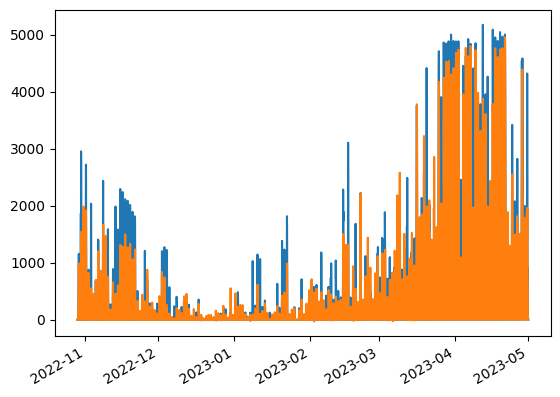

In [19]:
df = X_train_estimated_a[FEATURES]
df["prediction"] = reg_A.predict(X_train_estimated_a[FEATURES])

df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head(10))

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

C:\Users\elias\AppData\Local\Temp\ipykernel_7592\2473972573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prediction"] = reg_B.predict(X_train_estimated_b[FEATURES_b])


2023-04-28 11:00:00    602.995202
2023-04-28 12:00:00    560.038767
2023-04-08 11:00:00    526.690430
2023-04-30 12:00:00    508.817766
2023-04-28 10:00:00    463.758791
2023-04-08 12:00:00    425.746093
2023-04-14 09:00:00    377.373570
2023-03-16 12:00:00    353.662378
2023-04-08 10:00:00    353.177329
2023-03-16 10:00:00    350.113411
Name: error, dtype: float64

Mean Absolute Error: 18.903913015583125
MAE for the last 1000 values: 38.94126540778867


<Axes: >

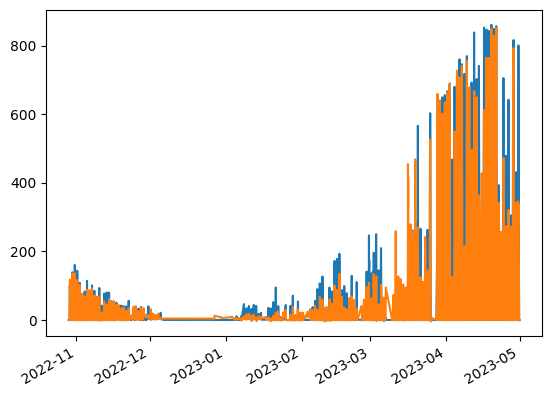

In [20]:
df = X_train_estimated_b[FEATURES_b]
df["prediction"] = reg_B.predict(X_train_estimated_b[FEATURES_b])

df = pd.merge(df, targets_b, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head(10))

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)
print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)
mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()

2023-04-28 14:00:00    342.808849
2023-04-14 11:00:00    341.354572
2023-03-19 10:00:00    332.764199
2023-04-28 13:00:00    314.207327
2023-04-28 11:00:00    313.947061
2023-04-24 09:00:00    304.160317
2023-03-27 11:00:00    301.443564
2023-04-28 15:00:00    300.618529
2023-03-27 12:00:00    299.215745
2023-04-07 09:00:00    285.417462
Name: error, dtype: float64

Mean Absolute Error: 18.0343481823782
MAE for the last 1000 values: 40.06050263201528


<Axes: >

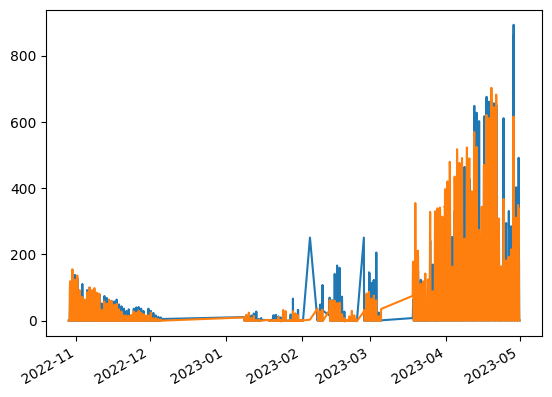

In [21]:
df = X_train_estimated_c[FEATURES]
df["prediction"] = reg_C.predict(X_train_estimated_c[FEATURES])

df = pd.merge(df, targets_c, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head(10))

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])
print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)
mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()


## Predicting on the actual test set

In [22]:
### Location B
A_pred = reg_A.predict(X_test_estimated_a[FEATURES])
A_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])
    

In [23]:
### Location B
B_pred = reg_B.predict(X_test_estimated_b[FEATURES_b])
B_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])

In [24]:
   
### Location C
C_pred = reg_C.predict(X_test_estimated_c[FEATURES])
C_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

## Storing the predictions

In [25]:
predictions = np.concatenate([A_pred_hourly, B_pred_hourly, C_pred_hourly])
# remove negative predictions
predictions = np.clip(predictions, a_min=0, a_max=None)
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})
df.to_csv("saves/xgboost3.csv", index=False)